# PART 3b - BERT + BLSTM DEEP LEARNING MODEL WITHOUT FINETUNING 

The code formatting below has been borrowed and adapted from Keras - https://keras.io/examples/nlp/semantic_similarity_with_bert/


In [ ]:
!pip install transformers==2.11.0

import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

     |████████████████████████████████| 674 kB 4.1 MB/s 
     |████████████████████████████████| 895 kB 26.5 MB/s 
     |████████████████████████████████| 1.2 MB 23.3 MB/s 
     |████████████████████████████████| 5.6 MB 23.2 MB/s 


In [ ]:
"""
## Configuration
"""

max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 4

#Labels in our dataset:
label = ["Not Sarcastic", "Sarcastic"]

In [ ]:
# Load dataset
from google.colab import files
uploaded = files.upload()

Saving sar_df.csv to sar_df.csv


In [ ]:
import io
sar_df = pd.read_csv(io.BytesIO(uploaded['sar_df.csv']), index_col=0)

In [ ]:
#Shuffle dataset 

In [ ]:
df = sar_df.sample(frac = 1, random_state = 0)


In [ ]:
data = df[["new_comment_lemm","new_pcomment_lemm" ]]
labels = df['label']

In [ ]:
data

,new_comment_lemm,new_pcomment_lemm
488303,just curious why do nt you start kd over pg,get about k mt anyif any suggestion on what to...
631998,eli why be so many mod so obsess with showcase...,please include a small explanation like one se...
116487,oh my god give they a pc case you piece of wet...,ascend my neighbor with some part I have lay a...
221152,cnn clinton neocon network,trump nail this on the head cnn clinton news n...
397186,all they have to do be hire micheal bay proble...,quick marketing department we need moar explos...
...,...,...
616921,its not real peanut,I m allergic to peanut though
1006703,you forget the,yep adam and eve
61530,well you do call yourself a destiny fan,I be mostly concerned with politic and law yup...
286009,cut he in half and send one half to algeria an...,habitat with all due respect they be from form...


In [ ]:
labels

488303     0
631998     1
116487     1
221152     0
397186     1
          ..
616921     0
1006703    1
61530      1
286009     1
111914     0
Name: label, Length: 150000, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X, test_df, y, y_test = train_test_split(data,labels,test_size=0.2,train_size=0.8)
train_df, valid_df, y_train, y_val = train_test_split(X,y,test_size = 0.16,train_size =0.84)

In [ ]:
train_df.shape

(100800, 2)

In [ ]:
train_df = train_df.reset_index(drop=True)

valid_df = valid_df.reset_index(drop=True)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train.values, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val.values, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test.values, num_classes=2)

In [ ]:
y_train, y_val, y_test

(array([[0., 1.],
        [1., 0.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [0., 1.]], dtype=float32), array([[1., 0.],
        [1., 0.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]], dtype=float32), array([[0., 1.],
        [1., 0.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [0., 1.]], dtype=float32))

In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


In [ ]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    sequence_output, pooled_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7ff5387237d0>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
___________________________

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["new_comment_lemm", "new_pcomment_lemm"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["new_comment_lemm", "new_pcomment_lemm"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
3150/3150 [==============================] - 2148s 675ms/step - loss: 0.6097 - acc: 0.6630 - val_loss: 0.5870 - val_acc: 0.6870
Epoch 2/4
3150/3150 [=

In [ ]:
test_data = BertSemanticDataGenerator(
    test_df[["new_comment_lemm", "new_pcomment_lemm"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

937/937 [==============================] - 486s 519ms/step - loss: 0.5508 - acc: 0.7143


[0.5508370995521545, 0.7143142819404602]

In [ ]:
def check_sarcasm(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data)[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = label[idx]
    return pred, proba

In [ ]:
sentence1 = "hes so skinny"
sentence2 = "no he's not...he is the fattest person in a third world country"
check_sarcasm(sentence1, sentence2)

('Sarcastic', ' 0.75%')

In [ ]:
sentence1 = "covid is not real"
sentence2 = "thousands of people are dying without access to healthcare"
check_sarcasm(sentence1, sentence2)

('Sarcastic', ' 0.51%')

In [ ]:
sentence1 = "i cant access my centrelink account"
sentence2 = "are you going to be ok"
check_sarcasm(sentence1, sentence2)

('Not Sarcastic', ' 0.95%')

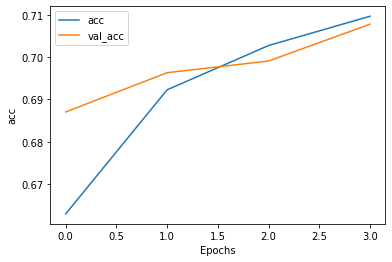

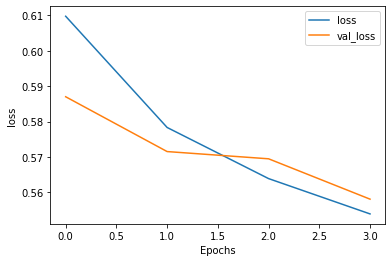

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")